# Implementation of Neural Style Transfer with PyTorch

In [1]:
# importing libraries to implement style-transfer

from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
# desired size of the output image
imsize = 128

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name, sizes:tuple):
    image = Image.open(image_name).resize(sizes)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

sizes = Image.open('../data/content.jpg').size
style_img = image_loader("../data/style2.jpg", sizes)
content_img = image_loader("../data/content.jpg", sizes)

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

In [30]:
style_img.size()

torch.Size([1, 3, 128, 187])

In [31]:
content_img.size()

torch.Size([1, 3, 128, 187])

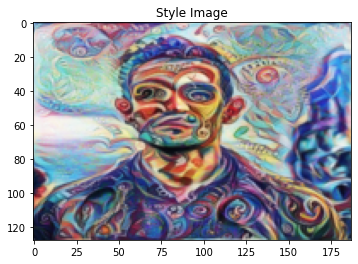

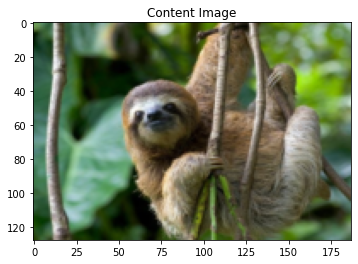

In [32]:
# visualizing the content and style images
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [33]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [34]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [35]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [36]:
cnn = models.vgg19(pretrained=True)
torch.save(cnn.state_dict(), '../data/models/vgg19.pth') # nothing else here
cnn.load_state_dict(torch.load("../data/models/vgg19.pth"))

<All keys matched successfully>

In [37]:
cnn = cnn.features.to(device).eval()

In [38]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [39]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

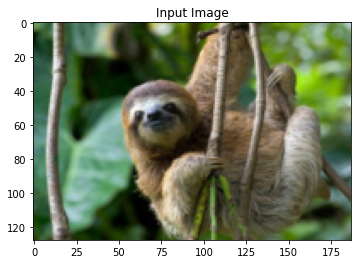

In [40]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [41]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [42]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=100000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..


C:\Users\Aleksey\AppData\Local\Temp\ipykernel_25084\1744401072.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
C:\Users\Aleksey\AppData\Local\Temp\ipykernel_25084\1744401072.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 21.086285 Content Loss: 45.480785

run [100]:
Style Loss : 7.197376 Content Loss: 36.073841

run [150]:
Style Loss : 5.273534 Content Loss: 30.656387

run [200]:
Style Loss : 4.477007 Content Loss: 27.239836

run [250]:
Style Loss : 3.894508 Content Loss: 25.431145

run [300]:
Style Loss : 3.534776 Content Loss: 24.262791



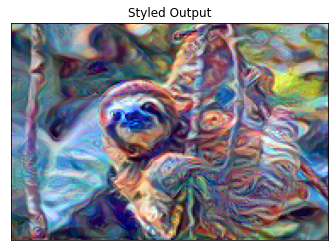

In [43]:
styled_output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
plt.xticks([])
plt.yticks([])
imshow(styled_output, title='Styled Output')

plt.show()

In [44]:
# importing libraries to implement style-transfer

# from __future__ import print_function
import warnings
warnings.simplefilter("ignore", UserWarning)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
import io
import copy
import numpy as np
import asyncio 



class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [2]:
class SlowStyleTransformer():
    def __init__(self, content_img: torch.Tensor, style_img: torch.Tensor, imsize: int=320):
        super(SlowStyleTransformer, self).__init__()
        self.cnn = models.vgg19()
        self.cnn.load_state_dict(torch.load("../data/models/vgg19.pth"))
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.imsize = imsize
        self.cnn = self.cnn.features.to(self.device).eval()
        self.content_img = self.image_loader(content_img)
        self.style_img = self.image_loader(style_img)
        self.input_img = self.content_img.clone()
        self.normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(self.device)
        self.normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(self.device)
        print("Model is ready")


    def image_loader(self, image_bytes: bytes):
        loader = transforms.Compose([
                            transforms.Resize(self.imsize),  # scale imported image
                            transforms.ToTensor()])  # transform it into a torch tensor
        self.unloader = transforms.ToPILImage()  # reconvert into PIL image
        
        image = Image.open(io.BytesIO(image_bytes))
        # fake batch dimension required to fit network's input dimensions
        image = loader(image).unsqueeze(0)
        return image.to(self.device, torch.float)

    def image_loader_file(self, image_name):
        loader = transforms.Compose([
                            transforms.Resize(self.imsize),  # scale imported image
                            transforms.ToTensor()])  # transform it into a torch tensor
        self.unloader = transforms.ToPILImage()  # reconvert into PIL image
        
        image = Image.open(image_name)
        # fake batch dimension required to fit network's input dimensions
        image = loader(image).unsqueeze(0)
        return image.to(self.device, torch.float)



    def get_input_optimizer(self, input_img):
    # this line to show that input is a parameter that requires a gradient
        optimizer = optim.LBFGS([input_img.requires_grad_()])
        return optimizer

        
    content_layers_default = ['conv_4']
    style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

    


    def get_style_model_and_losses(self):
        content_layers = SlowStyleTransformer.content_layers_default
        style_layers = SlowStyleTransformer.style_layers_default
        cnn = copy.deepcopy(self.cnn)

        # normalization module
        normalization = Normalization(self.normalization_mean,
                                 self.normalization_std).to(self.device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_losses = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(self.content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(self.style_img).detach()
                style_loss = StyleLoss(target_feature)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        # now we trim off the layers after the last content and style losses
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses


    async def run_style_transfer(self, 
                        num_steps=300, style_weight=100000, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, content_losses = self.get_style_model_and_losses()
        optimizer = self.get_input_optimizer(self.input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:
            await asyncio.sleep(0)
            def closure():
                # correct the values of updated input image
                self.input_img.data.clamp_(0, 1)

                optimizer.zero_grad()
                model(self.input_img)
                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss

                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), content_score.item()))
                    print()

                return style_score + content_score

            optimizer.step(closure)

        # a last correction...
        self.input_img.data.clamp_(0, 1)

        return self.input_img
    def imshow(self, tensor, title=None):
        image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
        image = image.squeeze(0)      # remove the fake batch dimension
        image = self.unloader(image)
        plt.imshow(image)
        if title is not None:
            plt.title(title)
        plt.pause(0.001)
    def image_to_bytes(self, input_img):
        # output = np.rollaxis(input_img.cpu().detach().numpy()[0], 0, 3)
        # output = Image.fromarray(np.uint8(output * 255))
        # buff = io.BytesIO()
        image = input_img.cpu().clone()  # we clone the tensor to not do changes on it
        image = image.squeeze(0)      # remove the fake batch dimension
        image = self.unloader(image)
        # torch.save(image, buff)
        # buff.seek(0)
        return image
    def image_to_byte_array(self, input_img: Image) -> bytes:
        image = input_img.cpu().clone()  # we clone the tensor to not do changes on it
        image = image.squeeze(0)      # remove the fake batch dimension
        image = self.unloader(image)
        imgByteArr = io.BytesIO()
        image.save(imgByteArr, format='JPEG')
        imgByteArr = imgByteArr.getvalue()
        return imgByteArr

In [3]:
import sys
sys.path.append('../')
from utils import DBHandler

In [4]:
db_handler = DBHandler()

Schema exists



In [5]:
db_handler.insert_picture_by_file(447558420, '../data/content.jpg', 'content')

Updated


In [6]:
content, style = db_handler.extract_picture(447558420)

In [10]:
# Image.open(io.BytesIO(content))

In [121]:
# content_img = '../data/content.jpg'
# style_img = '../data/style.jpg'

In [7]:
transformer = SlowStyleTransformer(content, style)

Model is ready


In [8]:
output_image = await transformer.run_style_transfer()

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 7.139669 Content Loss: 30.462801

run [100]:
Style Loss : 2.681704 Content Loss: 23.046228

run [150]:
Style Loss : 1.865340 Content Loss: 20.033060

run [200]:
Style Loss : 1.555157 Content Loss: 18.524267

run [250]:
Style Loss : 1.358278 Content Loss: 17.667221

run [300]:
Style Loss : 1.206932 Content Loss: 17.208935



In [9]:
sizes = Image.open(io.BytesIO(content)).size

In [12]:
pil_image = transforms.ToPILImage()(output_image.squeeze(0))

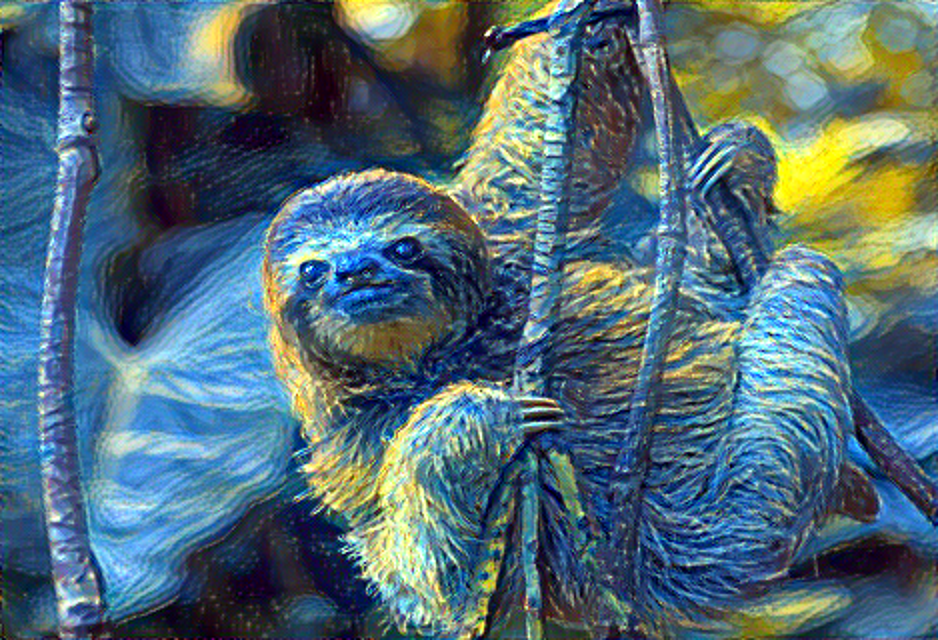

In [13]:
pil_image.resize(sizes)

In [14]:
del transformer

In [18]:
pil_image.thumbnail((400,400))

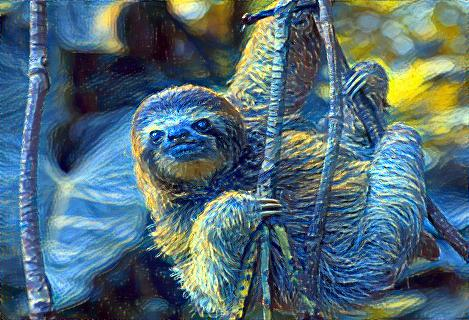

In [219]:
# transformer.unloader(output_image.squeeze(0))
show_im(transformer.image_to_byte_array(output_image))

In [132]:
check = output_image.clone()

In [143]:
buff = io.BytesIO()
torch.save(check, buff)
buff.seek(0)  # <--  this is what you were missing
byte_string = buff.read()

In [144]:
show_im(byte_string)

In [154]:
byteIO = io.BytesIO()
check.save(byteIO, format='JPEG')
byteArr = byteIO.getvalue()

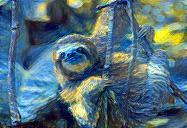

In [159]:
Image.open(io.BytesIO(byteArr))

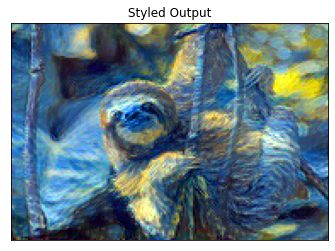

In [66]:
plt.figure()
plt.xticks([])
plt.yticks([])
transformer.imshow(output_image, title='Styled Output')

plt.show()

In [57]:
show_im(image_to_bytes(output_image))

In [22]:
buff.read()

b'PK\x03\x04\x00\x00\x08\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x10\x00\x12\x00archive/data.pklFB\x0e\x00ZZZZZZZZZZZZZZ\x80\x02ctorch._utils\n_rebuild_tensor_v2\nq\x00((X\x07\x00\x00\x00storageq\x01ctorch\nFloatStorage\nq\x02X\x01\x00\x00\x000q\x03X\x06\x00\x00\x00cuda:0q\x04J\x80\x18\x01\x00tq\x05QK\x00(K\x01K\x03K\x80K\xbbtq\x06(J\x80\x18\x01\x00M\x80]K\xbbK\x01tq\x07\x88ccollections\nOrderedDict\nq\x08)Rq\ttq\nRq\x0b.PK\x07\x08U\x94:\xa4\xae\x00\x00\x00\xae\x00\x00\x00PK\x03\x04\x00\x00\x08\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0e\x00\x16\x00archive/data/0FB\x12\x00ZZZZZZZZZZZZZZZZZZ(\x102?\x1b 7?~\x90\xe4>\xd6\xac\x81>-\xd7\xba>\xef\x97\x0e?\x8dL\xf8>\xcbM\xbb>n\xc5(>\tg/>j\xc7\x86=\x00\x00\x00\x00c\xc5\x08>FR.>\xaf\xf9&>\xae\x88\xe5=smu=\x0e\x10\x8f=V\xe2 >\xdc\xc4\xfc<1@$>o\xcc7>I\xe1\x05>)\xe2J>\x13l$>Kmw>)^\xe1=\xde\x8c\x84>\x19y|>\x1d\xd1z>]E8>\xf0\xf3A>\xe0\xd0K>L\xf8\x1c>\xe7yr>\xa1\xec\x98>\xa9Z?>\x

In [ ]:
# save styled image
from torchvision.utils import save_image 
save_image(styled_output, "lion-styled-with-26.jpg")